In [0]:
# 导入所需的包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 读取数据
attachment1 = pd.read_excel("CUMCM2023Problems/C题/6 个蔬菜品类的商品信息.xlsx")
attachment2 = pd.read_excel("CUMCM2023Problems/C题/销售流水明细数据.xlsx")
attachment3 = pd.read_excel("CUMCM2023Problems/C题/蔬菜类商品的批发价格.xlsx")

# Group by the date and product ID to get daily sales volume for each product
# Merge with attachment1 to get the category information/
daily_sales = attachment2.merge(attachment1, on='单品编码', how='left')

# Grouping the data by category and date
category_sales2 = daily_sales.groupby(['销售日期', '分类名称'])['销量(千克)'].mean().unstack()
category_sales2.replace(np.nan, 0, inplace=True)

Epoch 1/100
29/29 - 2s - loss: 0.0464 - 2s/epoch - 64ms/step
Epoch 2/100
29/29 - 0s - loss: 0.0200 - 44ms/epoch - 2ms/step
Epoch 3/100
29/29 - 0s - loss: 0.0084 - 41ms/epoch - 1ms/step
Epoch 4/100
29/29 - 0s - loss: 0.0058 - 43ms/epoch - 1ms/step
Epoch 5/100
29/29 - 0s - loss: 0.0056 - 42ms/epoch - 1ms/step
Epoch 6/100
29/29 - 0s - loss: 0.0055 - 41ms/epoch - 1ms/step
Epoch 7/100
29/29 - 0s - loss: 0.0055 - 41ms/epoch - 1ms/step
Epoch 8/100
29/29 - 0s - loss: 0.0054 - 42ms/epoch - 1ms/step
Epoch 9/100
29/29 - 0s - loss: 0.0054 - 40ms/epoch - 1ms/step
Epoch 10/100
29/29 - 0s - loss: 0.0053 - 43ms/epoch - 1ms/step
Epoch 11/100
29/29 - 0s - loss: 0.0053 - 43ms/epoch - 1ms/step
Epoch 12/100
29/29 - 0s - loss: 0.0052 - 40ms/epoch - 1ms/step
Epoch 13/100
29/29 - 0s - loss: 0.0052 - 43ms/epoch - 1ms/step
Epoch 14/100
29/29 - 0s - loss: 0.0051 - 41ms/epoch - 1ms/step
Epoch 15/100
29/29 - 0s - loss: 0.0051 - 42ms/epoch - 1ms/step
Epoch 16/100
29/29 - 0s - loss: 0.0051 - 40ms/epoch - 1ms/step
Ep

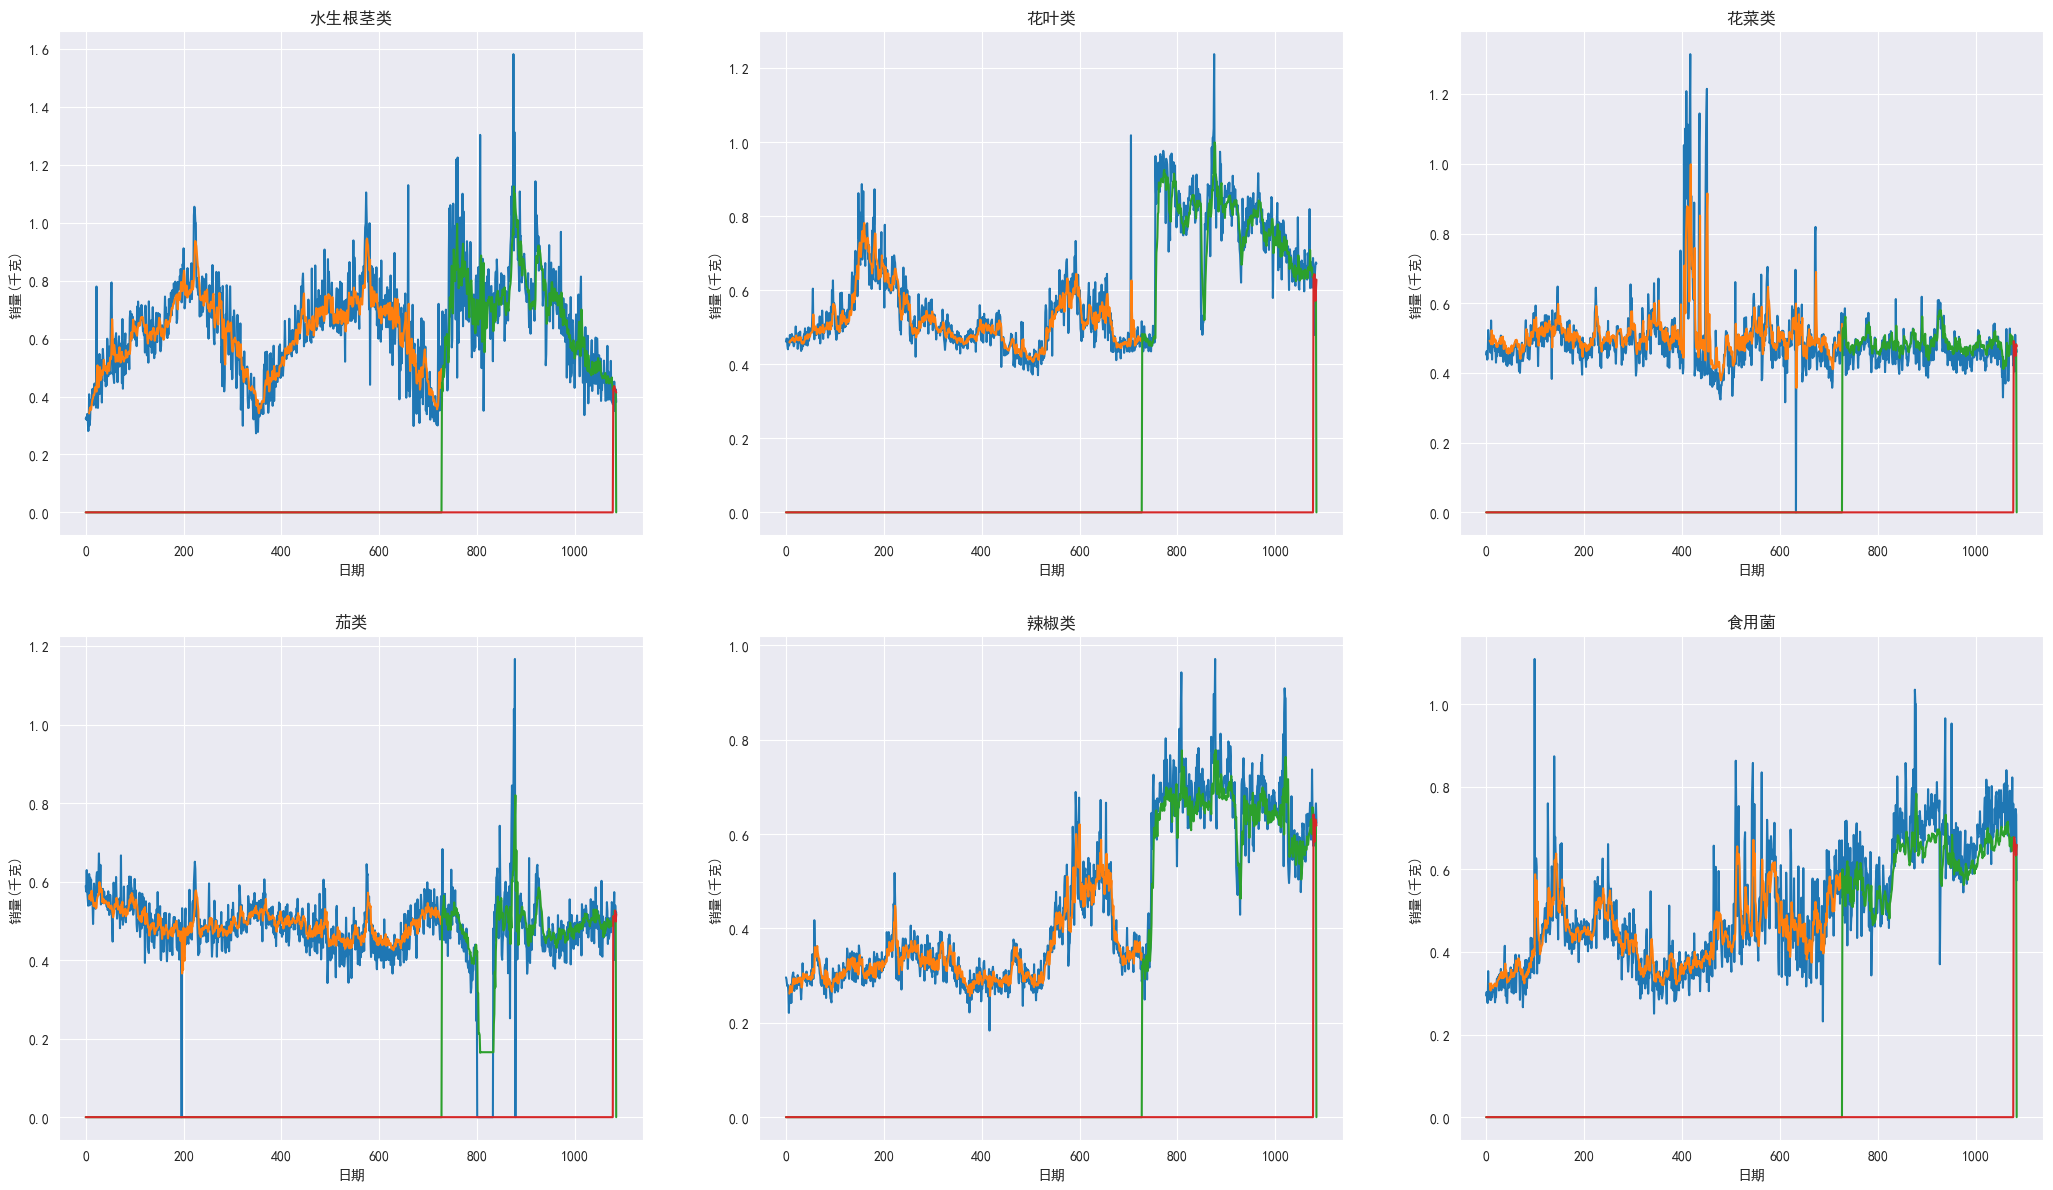

In [32]:
plt.figure(figsize=(25.60, 14.40))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
loc = 1
predictlist = []

for i in category_sales2.columns.values:
    plt.subplot(2, 3, loc)
    loc = loc + 1
    category_sales0 = category_sales2[i]
    look_back = 7
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(category_sales0.values.reshape(-1, 1))


    # 将时间序列数据转换为LSTM所需的格式
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)


    X, y = create_dataset(scaled_data, look_back)

    # # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(category_sales0.values.reshape(-1, 1))


    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)


    X, y = create_dataset(scaled_data, look_back)
    # 将数据划分为训练集和测试集
    train_size = int(len(X) * 0.67)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]
    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    # 创建LSTM模型
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=25, verbose=2)


    def create_dataset0(dataset, look_back=1):
        dataX = []
        for i in range(len(dataset) - look_back * 2 - 1, len(dataset) - look_back - 1):
            a = [dataset[i:(i + look_back), 0]]
            dataX.append(a)
        return np.array(dataX)


    unx = create_dataset0(scaled_data, look_back)
    predict = model.predict(unx)
    predict = scaler.inverse_transform(predict)

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # 反归一化
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])

    # 计算root mean squared error
    train_score = np.sqrt(np.mean((train_predict - y_train) ** 2))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(np.mean((test_predict - y_test) ** 2))
    print('Test Score: %.2f RMSE' % (test_score))

    X_train

    plt.plot(scaler.inverse_transform(scaled_data))
    train_predict_plot = np.zeros_like(scaled_data)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

    test_predict_plot = np.zeros_like(scaled_data)

    # print(scaler.inverse_transform(scaled_data))
    test_predict_plot[len(train_predict) + look_back:len(scaled_data) - 1, :] = test_predict

    predict_plot = np.zeros_like(scaled_data)
    predict_plot[len(predict_plot) - look_back:, :] = predict
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)
    plt.plot(predict_plot)
    plt.title(category_sales2[i].name)
    plt.xlabel('日期')
    plt.ylabel('销量(千克)')
    predictlist.append([category_sales2[i].name, predict.tolist()])
plt.show()
# '水生根茎类' '花叶类' '花菜类' '茄类' '辣椒类' '食用菌'

In [33]:
predictlist

[['水生根茎类',
  [[0.4236217439174652],
   [0.43084844946861267],
   [0.43605920672416687],
   [0.42890241742134094],
   [0.42322948575019836],
   [0.4187353253364563],
   [0.41382575035095215]]],
 ['花叶类',
  [[0.6368228793144226],
   [0.6359113454818726],
   [0.6434217095375061],
   [0.6241925954818726],
   [0.571599543094635],
   [0.5979909896850586],
   [0.628818690776825]]],
 ['花菜类',
  [[0.4916079044342041],
   [0.47104379534721375],
   [0.463327556848526],
   [0.4540502727031708],
   [0.4495123326778412],
   [0.48232051730155945],
   [0.47703415155410767]]],
 ['茄类',
  [[0.511073887348175],
   [0.5128078460693359],
   [0.5048611760139465],
   [0.5069512724876404],
   [0.5266247391700745],
   [0.49861249327659607],
   [0.5169232487678528]]],
 ['辣椒类',
  [[0.6413861513137817],
   [0.627602756023407],
   [0.583676815032959],
   [0.6206626892089844],
   [0.6307582855224609],
   [0.6264176368713379],
   [0.6178984045982361]]],
 ['食用菌',
  [[0.6544017791748047],
   [0.6777324676513672],
   [0.6

In [65]:
predictlist0 = pd.DataFrame(predictlist,columns=['品类名','pre'])
coeflist = pd.DataFrame([['水生根茎类', 62.20465133692592, -2.27165120328462, -0.010203565748189793],[
                            '花叶类', 402.624615230166, -59.73534088591999, 3.7123851795086926], [
                            '花菜类', 55.84356367645502, -1.034397988825084, -0.07833774776211494], [
                            '茄类', 63.21167061781499, -8.342338853787828, 0.3794560907615357], [
                            '辣椒类', 179.0262741751165, -15.674648386601197, 0.529141176182987], [
                            '食用菌', 100.97902028466109, 1.8065125543475193, -0.34162165813835077]],columns=['品类名','intercept_','coef_1','coef_2'])

In [66]:
predictlist0.head()

,品类名,pre
0,水生根茎类,"[[0.4236217439174652], [0.43084844946861267], ..."
1,花叶类,"[[0.6368228793144226], [0.6359113454818726], [..."
2,花菜类,"[[0.4916079044342041], [0.47104379534721375], ..."
3,茄类,"[[0.511073887348175], [0.5128078460693359], [0..."
4,辣椒类,"[[0.6413861513137817], [0.627602756023407], [0..."


In [67]:
coeflist.head()

,品类名,intercept_,coef_1,coef_2
0,水生根茎类,62.204651,-2.271651,-0.010204
1,花叶类,402.624615,-59.735341,3.712385
2,花菜类,55.843564,-1.034398,-0.078338
3,茄类,63.211671,-8.342339,0.379456
4,辣椒类,179.026274,-15.674648,0.529141


In [69]:
result=coeflist.merge(predictlist0,on='品类名',how='left')
result.set_index('品类名',inplace=True)

In [85]:
for i in result.index:
    temp= [i]
    for j in result.loc[i]['pre']:
        temp.append(result.loc[i]['intercept_']+j[0]*result.loc[i]['coef_1']+j[0]*result.loc[i]['coef_2']*result.loc[i]['coef_2'])
    print(temp)

['水生根茎类', 61.24237459704468, 61.225958795075854, 61.214122314592544, 61.23037929851091, 61.243265629943274, 61.25347432695549, 61.26462665772955]
['花叶类', 373.3603513781421, 373.40223958199323, 373.0571117882409, 373.94075759564424, 376.35759438313585, 375.14481406140777, 373.72817215357935]
['花菜类', 55.338062349545055, 55.35920762474595, 55.36714193329684, 55.37668140449593, 55.38134759208884, 55.34761220925384, 55.353047973967485]
['茄类', 59.02170702762696, 59.00749142380057, 59.07264102157808, 59.05550567512123, 58.89421567159574, 59.12386992175137, 58.97375190414869]
['辣椒类', 169.15235372824935, 169.36454438485475, 170.04076922383052, 169.47138433997569, 169.31596608740074, 169.38278888889278, 169.51393955617908]
['食用菌', 102.2375775077901, 102.2824475057595, 102.26216806045014, 102.24109742010423, 102.23604234639784, 102.19892048863636, 102.24774233501056]
